In [188]:
import numpy as np
import numba
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

def d2np(d):
    
    names = []
    numbers = ()
    dtypes = []
    for item in d:
        names += item   
        if type(d[item]) == float:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == np.ndarray:
            numbers += (d[item],)
            dtypes += [(item,np.float64,d[item].shape)]
    return np.array([numbers],dtype=dtypes)

In [189]:
# [1] D. Ochoa and S. Martinez, 
# “Fast-Frequency Response provided by DFIG-Wind Turbines and its impact on the grid,” 
# IEEE Trans. Power Syst., vol. 8950, no. c, pp. 1–1, 2016.

@numba.jit(nopython=True, cache=True)
def wind_turbine_fit(struct):

    nu_w = struct['nu_w']    # m/s
    omega_t = struct['omega_t'] # rad/s
    beta = struct['beta']       # deg

    C_1 = struct['C_1']
    C_2 = struct['C_2']
    C_3 = struct['C_3']
    C_4 = struct['C_4']
    C_5 = struct['C_5']
    C_6 = struct['C_6']
    
    #Omega_t_n = struct['Omega_t_n'] # 
    R = struct['R']
    Rho = struct['Rho']  

    lam = omega_t*R/nu_w
    inv_lam_i = 1/(lam + 0.08 * beta) - 0.035/(beta**3 + 1)
    c_p = C_1 * (C_2 * inv_lam_i - C_3 * beta - C_4) * np.exp(-C_5*inv_lam_i) + C_6 * lam
    
    p_w = 0.5*Rho*np.pi*R**2*nu_w**3*c_p
    
    tau_t = np.array([0.001])
    if omega_t[0]>0.0:
        tau_t = p_w/omega_t
    
                
        
    struct['p_w'][:] = p_w
    struct['c_p'][:] = c_p
    struct['lam'][:] = lam
    struct['tau_t'][:] = tau_t

    return p_w


@numba.jit(nopython=True, cache=True)
def mppt_fit(struct):

    omega_t = struct['omega_t'] # rad/s

    C_1 = struct['C_1']
    C_2 = struct['C_2']
    C_3 = struct['C_3']
    C_4 = struct['C_4']
    C_5 = struct['C_5']
    C_6 = struct['C_6']
    lam_opt = struct['lam_opt']
    beta = struct['beta']
    
    #Omega_t_n = struct['Omega_t_n'] # 
    R = struct['R']
    Rho = struct['Rho']  

    inv_lam_i = 1/(lam_opt + 0.08 * beta) - 0.035/(beta**3 + 1)
    c_p = C_1 * (C_2 * inv_lam_i - C_3 * beta - C_4) * np.exp(-C_5*inv_lam_i) + C_6 * lam_opt
    
    #lam = omega_t*R/nu_w
    nu_w = omega_t*R/lam_opt
    p_ref = 0.5*Rho*np.pi*R**2*nu_w**3*c_p

    struct['p_mppt'][:] = p_ref
    return p_ref


@numba.jit(nopython=True, cache=True)
def wecs_mech_1(struct):

    omega_t = struct[0]['x'][0]  # rad/s
    tau_t = struct['tau_t']
    tau_r = struct['tau_r']
       
    J_t = struct['J_t']
    N_tr = struct['N_tr']
    Dt = struct['Dt']

    domega_t = 1.0/J_t*(tau_t - N_tr*tau_r)

    omega_r = N_tr*omega_t 
    
    struct[0]['f'][:,0] = domega_t

    struct['omega_r'][:] = omega_r
    struct['omega_t'][:] = omega_t
    p_w = wind_turbine_fit(struct)   

    return omega_t


In [190]:
N = 100

#nu_w =np.linspace(0.1,15,N)
H = 4.5

# H = 0.5*J*Omega_t_n**2/S_b
S_b = 2.0e6
Omega_t_n = 1.5
J_t = 2*H*S_b/Omega_t_n**2

d = dict(R=50.0,
         Rho = 1.225,
         C_1 = 0.5176,
         C_2 = 116.0,
         C_3 = 0.4,
         C_4 = 5.0,
         C_5 = 21.0,
         C_6 = 0.0068,
         nu_w =10.0,
         omega_t = 1.0,
         beta = 0.0,
         Omega_t_n = Omega_t_n,
         Nu_w_n = 11.0,
         p_w = 0.0,
         c_p = 0.0,
         lam = 0.0,
         lam_opt = 8.0,
         J_t = J_t,     
         N_tr = 20.0,  
         x = np.zeros((1,1)),
         f = np.zeros((1,1)),
         omega_r = 1.0,
         tau_t = 10.0,
         tau_r = 0.0,
         Dt = 1.0e-3,
         p_mppt = 1.0
        )
 
struct = d2np(d)
wind_turbine_fit(struct)
mppt_fit(struct)

array([ 563479.01858822])

<IPython.core.display.Javascript object>


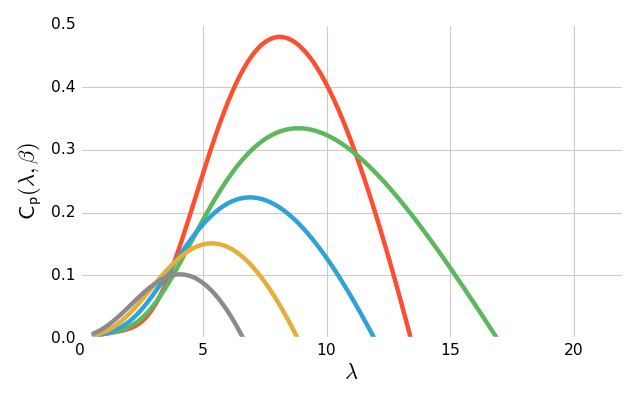

In [191]:
struct = d2np(d)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
betas = np.linspace(0.0,24,5)
omegas = np.linspace(0.1,3.5,100)
for beta in betas:
    C_p = []
    Lam = []
    for omega in omegas:
        struct['beta'] = beta
        struct['omega_t'] = omega
        wind_turbine_fit(struct)
        C_p += [float(struct['c_p'])]
        Lam += [float(struct['lam'])]
    axes.plot(np.array(Lam),np.array(C_p))
    axes.set_ylabel('$\sf C_p ( \lambda,\\beta )$')
    axes.set_xlabel('$\sf \lambda$')
    axes.set_ylim([0,0.5])
    axes.set_xlim([0,22])
    data[0]['c_p']

fig.savefig('lam_cp.svg', bbox_inches='tight')


<IPython.core.display.Javascript object>


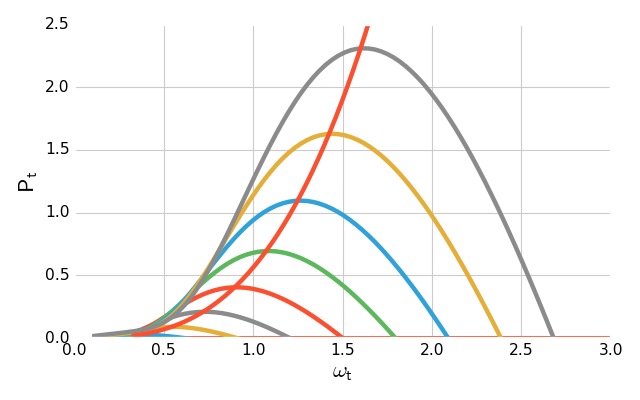

In [192]:
struct = d2np(d)
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
data['beta'] = 0.0
nu_ws = np.linspace(0.1,10,10)
omegas = np.linspace(0.1,3.5,100)
for nu_w in nu_ws:
    P_w = []
    Omega = []
    for omega in omegas:
        struct['nu_w'] = nu_w
        struct['omega_t'] = omega
        wind_turbine_fit(struct)
        P_w += [float(struct['p_w'])]
        Omega += [float(struct['omega_t'])]
    axes.plot(Omega,np.array(P_w)/1e6)

omega = 1
Nu = np.linspace(2,12,50)
omegas_opt = []
p_ref_opt = []
for nu in Nu:
    struct['nu_w'] = nu
    for it in range(500):
        struct['omega_t'] = omega
        mppt_fit(struct)  
        wind_turbine_fit(struct)  
        p_ref = float(struct['p_mppt'])
        p_t = float(struct['p_w'])
        omega += 0.0000001*(-p_ref + p_t)/omega
        if abs(-p_ref + p_t)<0.01:
            break
    
    omegas_opt += [float(struct['omega_t'])]
    p_ref_opt += [float(struct['p_w'])] 
        
axes.set_ylabel('$\sf P_t$')
axes.set_xlabel('$\sf \omega_t$')
axes.set_ylim([0,2.5])
axes.set_xlim([0,3.0])

fig.savefig('w_p_t.svg', bbox_inches='tight')
axes.plot(np.array(omegas_opt),np.array(p_ref_opt)/1e6)   

fig.savefig('w_p_t_mppt.svg', bbox_inches='tight')


## without MPPT

In [195]:
struct = d2np(d)
struct['nu_w'] = 5.0
for it in range(10000):
    wecs_mech_1(struct)
    struct[0]['x'] += 100.0e-3*struct[0]['f'][0,0]
print(struct['omega_t'])
print(struct['p_w']/1e6)

[ 1.34019824]
[  1.15077521e-14]


## with MPPT

In [216]:
struct['omega_t'] = 1.0
struct['omega_r'] = 1.0*20
struct['nu_w'] = 8.5
t = 0.0
Omega_t = []
P_w = []
T = []
Dt = 100.0e-3
for it in range(500):
    if t>10.0:
        struct['nu_w'] = 6.0
        
    wecs_mech_1(struct)
    mppt_fit(struct)  
    struct['tau_t'] = struct['p_w']/struct['omega_t']
    struct['tau_r'] = struct['p_mppt']/struct['omega_r']
    wind_turbine_fit(struct)  
    struct[0]['x'] += Dt*struct[0]['f'][0,0]
    struct['omega_t'] = float(struct[0]['x'])
    Omega_t += [float(struct['omega_t'])]
    P_w += [float(struct['p_w'])]
    T += [t]
    t+= Dt
P_w = np.array(P_w)
print(struct['omega_t'])
print(struct['p_w']/1e6)

[ 0.96007976]
[ 0.49853344]


<IPython.core.display.Javascript object>


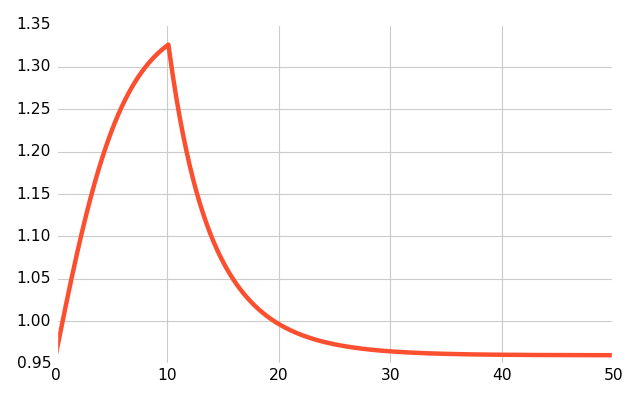

In [217]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)

axes.plot(T,Omega_t)


<IPython.core.display.Javascript object>


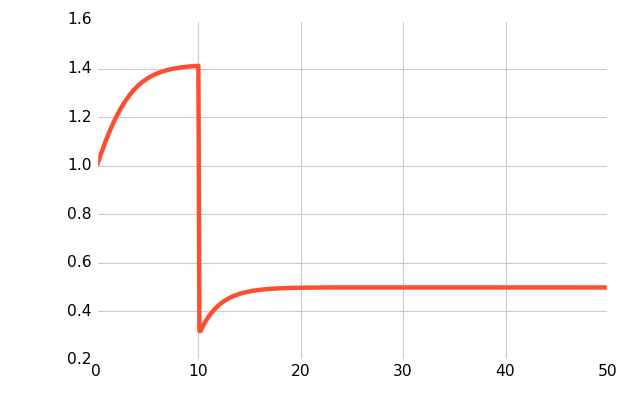

In [218]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)

axes.plot(T,P_w/1e6)